In [1]:
@info pwd()
import Pkg.activate as pactivate
pactivate("../../")
JULIA_DEBUG=Main
using Plots, Statistics, DelimitedFiles, Unitful
pyplot()

[ Info: /Users/jun/codes/SPM.jl/test/notebooks
  Activating project at `~/codes/SPM.jl`


Plots.PyPlotBackend()

In [33]:
include("../../src/SPM.jl")

Main.SPM

[ Info: (10, 10)
[ Info: (30, 30)


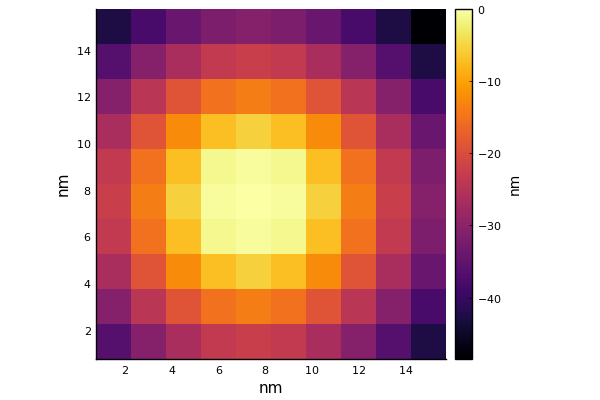

In [3]:
using BSON: @load
@load "../data/single_tip_test_data.bson" resolution tip surfs images images_randn
resolution = resolution / 10.0 # 解像度[nm/px]
# 変換、画素値は\AAからnmに変換
surfs = [SPM.Image(mat/10.0, resolution) for mat in surfs] # 実表面
images = [SPM.Image(mat/10.0, resolution) for mat in images] # ノイズなし画像
noisy_images = [SPM.Image(mat/10.0, resolution) for mat in images_randn] # ノイズあり画像
true_tip = SPM.Tip(tip/10.0, resolution) # 探針

@info size(true_tip.data)
@info size(images[1].data)
SPM.Plots.heatmap(true_tip)

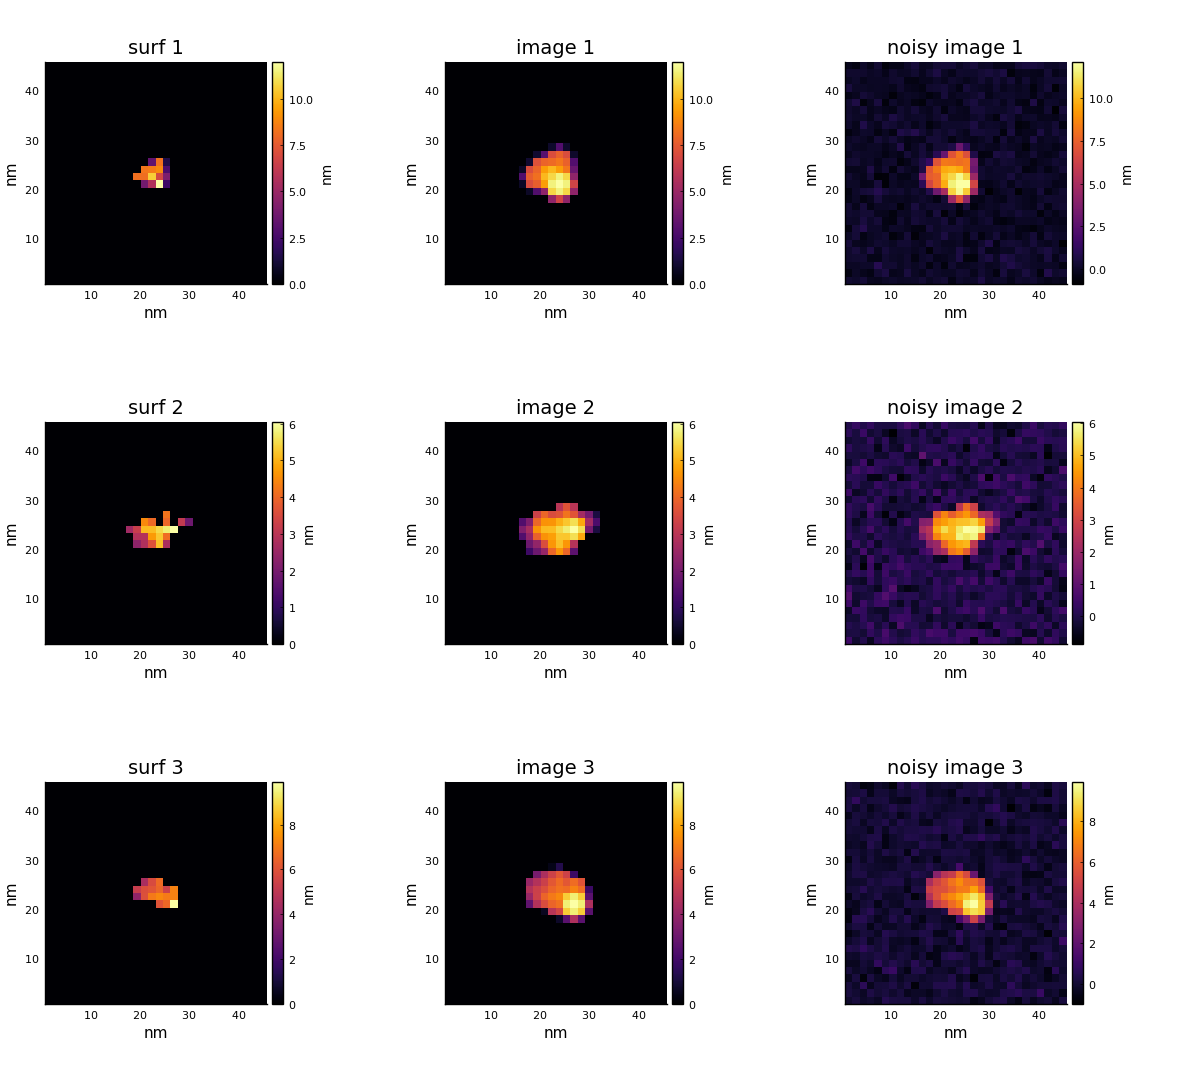

In [4]:
ps = Vector{Plots.Plot}(undef, 9)
for i in 0:2
    ps[3i+1] = SPM.Plots.heatmap(surfs[i+1]; title="surf $(i+1)")
    ps[3i+2] = SPM.Plots.heatmap(images[i+1]; title="image $(i+1)")
    ps[3i+3] = SPM.Plots.heatmap(noisy_images[i+1]; title="noisy image $(i+1)")
end
plot(ps..., layout=(3,3), size=(1200, 1080))

In [5]:
downscale_ratio = 1
tip_size = div(size(true_tip.data, 1), downscale_ratio)
max_epoch = 80
lambdas = [1.0e-7, 1.0e-6, 1e-5, 1.0e-4, 1e-3, 1e-2]
lambdas = [1.0e-10, 1e-8, 1e-5, 1e-4, 1e-3, 1e-2, 1e-0, 5, 10]
@time results = SPM.BTR.solveDifferentiableBTR(
    images, tip_size, max_epoch, lambdas; downscale_ratio=downscale_ratio, debug_interval=0
)
println(typeof(results))

[ Info: 1th thread : start solving for lambda = 1.0e-10
[ Info: 3th thread : start solving for lambda = 0.01
[ Info: 4th thread : start solving for lambda = 5.0
[ Info: 2th thread : start solving for lambda = 0.0001
[ Info: 3th thread : optimizer setup completed
[ Info: 2th thread : optimizer setup completed
[ Info: 1th thread : optimizer setup completed
[ Info: 4th thread : optimizer setup completed
[ Info: 4th thread : 80th epoch completed in 28.151 sec
[ Info: 2th thread : 8th lambda completed
[ Info: 1th thread : start solving for lambda = 10.0
[ Info: 3th thread : optimizer setup completed
[ Info: 3th thread : 80th epoch completed in 28.158 sec
[ Info: 2th thread : 4th lambda completed
[ Info: 4th thread : start solving for lambda = 0.001
[ Info: 1th thread : optimizer setup completed
[ Info: 4th thread : 80th epoch completed in 28.187 sec
[ Info: 1th thread : 80th epoch completed in 28.187 sec
[ Info: 3th thread : 1th lambda completed
[ Info: 2th thread : 6th lambda completed
[ I

 34.058898 seconds (84.10 M allocations: 8.052 GiB, 5.93% gc time, 79.50% compilation time)


[ Info: 3th thread : 80th epoch completed in 1.192 sec
[ Info: 3th thread : 3th lambda completed


Vector{Main.SPM.BTR.DifferentiableBTRResult}


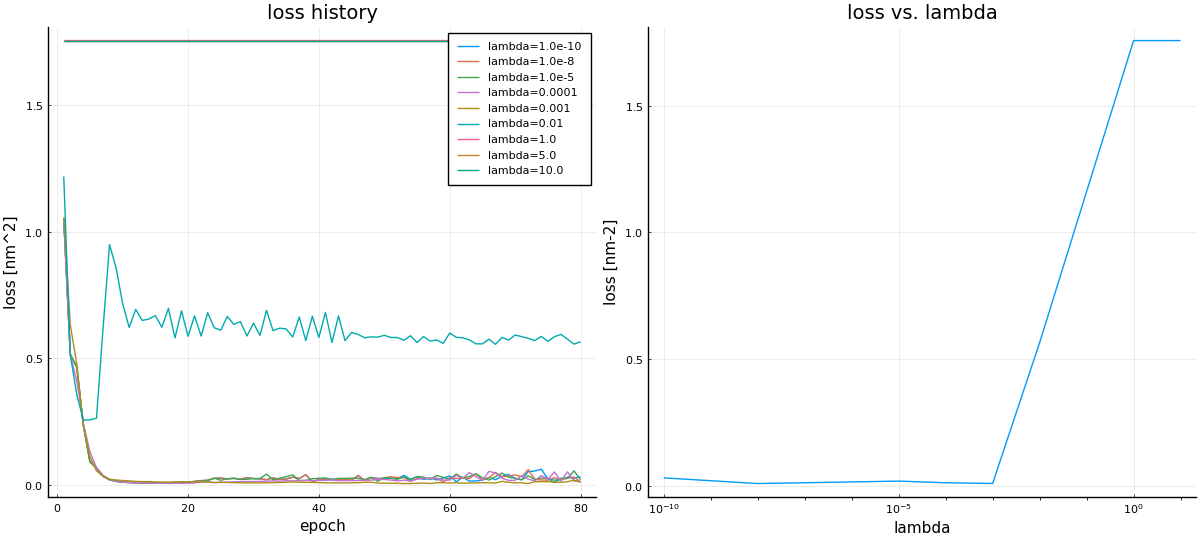

In [6]:
ps = Vector{Plots.Plot}(undef, 2)

ps[1] = plot(xlabel="epoch", ylabel="loss [nm^2]", title="loss history")
for it in eachindex(lambdas)
    plot!(ps[1], collect(1:max_epoch), results[it].loss_history, label="lambda=$(lambdas[it])")
end

ps[2] = plot(
    lambdas, [result.loss_history[end] for result in results],
    xaxis=:log, xlabel="lambda", ylabel="loss [nm-2]", title="loss vs. lambda", legend=nothing
)

plot(ps..., layout=(1,2), size=(1200, 540))

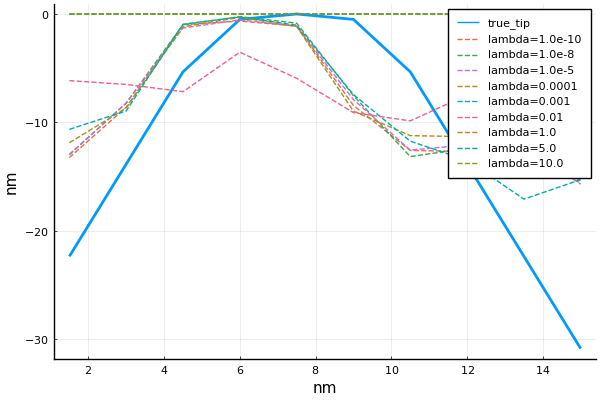

In [7]:
slice_direction = :x
i_slice = div(size(results[1].tip.data,1), 2) 
p = SPM.Plots.plotProfile(true_tip, slice_direction, i_slice; linewidth=2, label="true_tip")
for result in results
    p = SPM.Plots.plotProfile!(p, result.tip, slice_direction, i_slice; linestyle=:dash, label="lambda=$(result.lambda)")
end
p

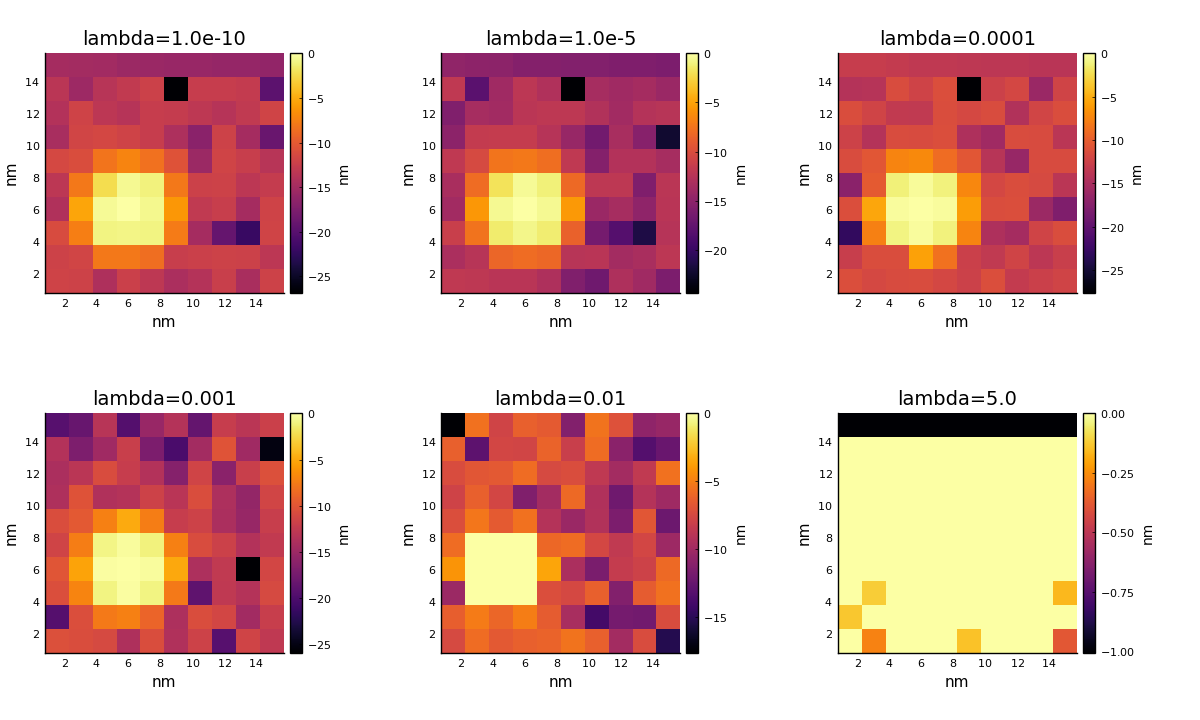

In [8]:
ps = Vector{Plots.Plot}(undef, 6)
# ps[1] = SPM.Plots.heatmap(true_tip; title="true tip")
for (i, i_lambda) in zip(1:6, [1,3,4,5,6,8])
    result = results[i_lambda]
    ps[i] = SPM.Plots.heatmap(result.tip; title="lambda=$(result.lambda)")
end
plot(ps..., layout=(2,3), size=(1200, 720))

[ Info: size:(512, 512)   resolution:0.1953125


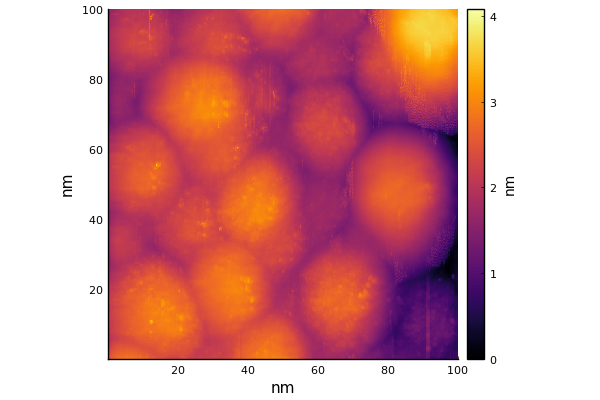

In [34]:
image = SPM.HDR.loadHDR("../data/B3446.hdr")
@info "size:$(size(image.data))   resolution:$(image.resolution)"
SPM.Plots.heatmap(image; legend=true)

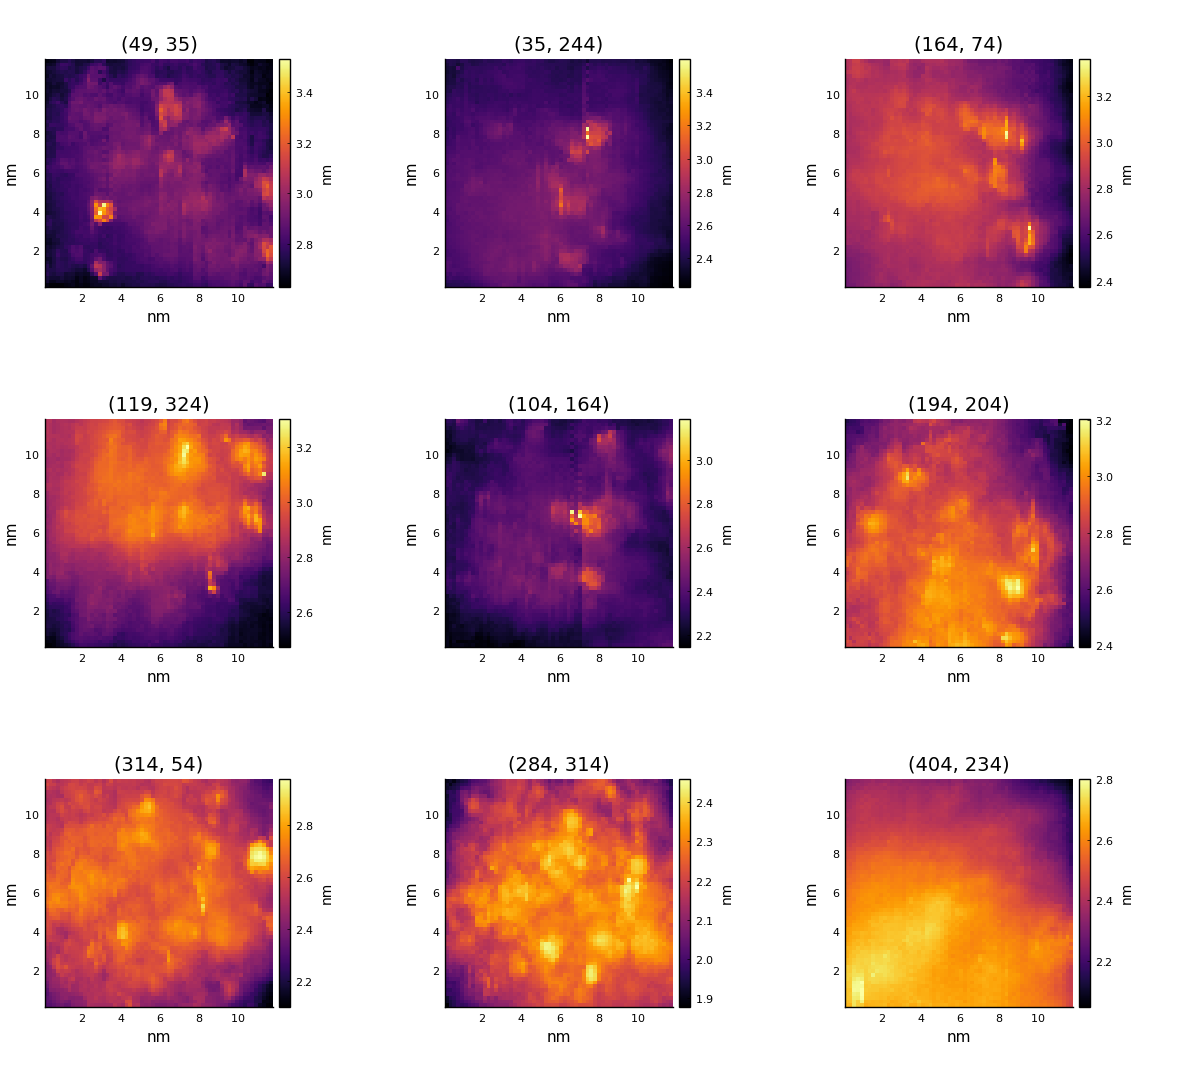

In [35]:
halfwidth = 30
extract_size = (2*halfwidth, 2*halfwidth)
centers = [
    (79,65), (65,274), (194, 104), 
    (149,354), (134,194), (224,234), 
    (344,84), (314,344), (434,264)
]
lowerlefts = [(p[1]-halfwidth, p[2]-halfwidth) for p in centers]
plots = Vector{Plots.Plot}(undef, length(lowerlefts))
extracted_images = SPM.extract(image, lowerlefts, extract_size)
for i = eachindex(lowerlefts)
    plots[i] = SPM.Plots.heatmap(extracted_images[i]; title="$(lowerlefts[i])", legend=true)
end

plot(plots..., layout=(3,3), size=(1200, 1080))

In [36]:
downscale_ratio = 1
tip_size = 20
max_epoch = 20
# lambdas = [1.0e-11, 1.0e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]
lambdas = [1e-3, 1e-2, 1e-1, 1]
@time normalResults = SPM.BTR.solveDifferentiableBTR(
    extracted_images, tip_size, max_epoch, lambdas; downscale_ratio=downscale_ratio
)
SPM.BTR.saveResults(extracted_images, normalResults, "normalResults")

[ Info: 1th thread : start solving for lambda = 0.001
[ Info: 2th thread : start solving for lambda = 0.01
[ Info: 3th thread : start solving for lambda = 0.1
[ Info: 4th thread : start solving for lambda = 1.0
[ Info: 1th thread : optimizer setup completed
[ Info: 3th thread : optimizer setup completed
[ Info: 4th thread : optimizer setup completed
[ Info: 2th thread : optimizer setup completed
[ Info: 3th thread : 20th epoch completed in 3.699 sec
[ Info: 1th thread : 2th lambda completed
[ Info: 3th thread : 20th epoch completed in 3.713 sec
[ Info: 1th thread : 1th lambda completed


  4.005416 seconds (4.09 M allocations: 1.599 GiB, 13.17% gc time, 24.71% compilation time)


[ Info: 1th thread : 20th epoch completed in 3.728 sec
[ Info: 1th thread : 3th lambda completed
[ Info: 1th thread : 20th epoch completed in 3.753 sec
[ Info: 1th thread : 4th lambda completed


true

In [12]:
downscale_ratio = 2
tip_size = 20
max_epoch = 200
lambdas = [1.0e-11, 1.0e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]
@time downScaledResults = SPM.BTR.solveDifferentiableBTR(
    extracted_images, tip_size, max_epoch, lambdas; downscale_ratio=downscale_ratio
)
SPM.BTR.saveResults(extracted_images, downScaledResults, "downScaledResults")

[ Info: 1th thread : start solving for lambda = 1.0e-11
[ Info: 2th thread : start solving for lambda = 1.0e-8
[ Info: 3th thread : start solving for lambda = 0.01
[ Info: 4th thread : start solving for lambda = 1.0e-5
[ Info: 1th thread : optimizer setup completed
[ Info: 3th thread : optimizer setup completed
[ Info: 4th thread : optimizer setup completed
[ Info: 2th thread : optimizer setup completed
[ Info: 3th thread : 20th epoch completed in 12.982 sec
[ Info: 3th thread : 20th epoch completed in 13.233 sec
[ Info: 1th thread : 20th epoch completed in 13.338 sec
[ Info: 1th thread : 20th epoch completed in 13.67 sec
[ Info: 4th thread : 40th epoch completed in 25.808 sec
[ Info: 1th thread : 40th epoch completed in 25.961 sec
[ Info: 4th thread : 40th epoch completed in 26.328 sec
[ Info: 1th thread : 40th epoch completed in 26.721 sec
[ Info: 4th thread : 60th epoch completed in 38.647 sec
[ Info: 2th thread : 60th epoch completed in 39.086 sec
[ Info: 4th thread : 60th epoch co

[ Info: 4th thread : 160th epoch completed in 104.46 sec
[ Info: 1th thread : 160th epoch completed in 104.216 sec
[ Info: 1th thread : 160th epoch completed in 103.0 sec
[ Info: 4th thread : 180th epoch completed in 116.23 sec
[ Info: 2th thread : 180th epoch completed in 117.214 sec
[ Info: 4th thread : 180th epoch completed in 115.92 sec
[ Info: 1th thread : 180th epoch completed in 117.488 sec
[ Info: 4th thread : 200th epoch completed in 128.913 sec
[ Info: 1th thread : 2th lambda completed
[ Info: 1th thread : start solving for lambda = 1.0e-9
[ Info: 2th thread : optimizer setup completed
[ Info: 2th thread : 200th epoch completed in 129.802 sec
[ Info: 4th thread : 8th lambda completed
[ Info: 1th thread : start solving for lambda = 0.001
[ Info: 2th thread : optimizer setup completed
[ Info: 1th thread : 200th epoch completed in 129.029 sec
[ Info: 2th thread : 5th lambda completed
[ Info: 3th thread : start solving for lambda = 1.0e-6
[ Info: 3th thread : optimizer setup comp

393.241284 seconds (78.22 M allocations: 131.203 GiB, 8.35% gc time)


[ Info: 2th thread : 200th epoch completed in 133.019 sec
[ Info: 2th thread : 12th lambda completed


LoadError: InexactError: trunc(UInt16, NaN)

In [13]:
downscale_ratio = 1
tip_size = 40
max_epoch = 200
lambdas = [1.0e-11, 1.0e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]
@time largeGridResults = SPM.BTR.solveDifferentiableBTR(
    extracted_images, tip_size, max_epoch, lambdas; downscale_ratio=downscale_ratio
)
SPM.BTR.saveResults(extracted_images, largeGridResults, "largeGridResults")

[ Info: 1th thread : start solving for lambda = 1.0e-11
[ Info: 2th thread : start solving for lambda = 1.0e-8
[ Info: 3th thread : start solving for lambda = 1.0e-5
[ Info: 1th thread : start solving for lambda = 0.01
[ Info: 3th thread : optimizer setup completed
[ Info: 4th thread : optimizer setup completed
[ Info: 2th thread : optimizer setup completed
[ Info: 1th thread : optimizer setup completed
[ Info: 2th thread : 20th epoch completed in 15.437 sec
[ Info: 4th thread : 20th epoch completed in 15.459 sec
[ Info: 1th thread : 20th epoch completed in 15.634 sec
[ Info: 1th thread : 20th epoch completed in 16.038 sec
[ Info: 1th thread : 40th epoch completed in 30.237 sec
[ Info: 3th thread : 40th epoch completed in 30.795 sec
[ Info: 3th thread : 40th epoch completed in 31.052 sec
[ Info: 3th thread : 40th epoch completed in 31.487 sec
[ Info: 3th thread : 60th epoch completed in 45.194 sec
[ Info: 3th thread : 60th epoch completed in 45.879 sec
[ Info: 4th thread : 60th epoch c

[ Info: 1th thread : 160th epoch completed in 121.047 sec
[ Info: 2th thread : 160th epoch completed in 121.292 sec
[ Info: 3th thread : 160th epoch completed in 121.378 sec
[ Info: 1th thread : 180th epoch completed in 135.382 sec
[ Info: 1th thread : 180th epoch completed in 135.822 sec
[ Info: 1th thread : 180th epoch completed in 135.885 sec
[ Info: 1th thread : 180th epoch completed in 136.076 sec
[ Info: 2th thread : 200th epoch completed in 149.967 sec
[ Info: 4th thread : 5th lambda completed
[ Info: 1th thread : start solving for lambda = 1.0e-6
[ Info: 2th thread : optimizer setup completed
[ Info: 4th thread : 200th epoch completed in 150.657 sec
[ Info: 3th thread : 2th lambda completed
[ Info: 1th thread : start solving for lambda = 1.0e-9
[ Info: 2th thread : optimizer setup completed
[ Info: 3th thread : 200th epoch completed in 150.587 sec
[ Info: 3th thread : 8th lambda completed
[ Info: 1th thread : start solving for lambda = 0.001
[ Info: 2th thread : optimizer setup

449.700531 seconds (78.22 M allocations: 441.182 GiB, 15.10% gc time)


[ Info: 2th thread : 200th epoch completed in 150.595 sec
[ Info: 2th thread : 9th lambda completed


LoadError: InexactError: trunc(UInt16, NaN)

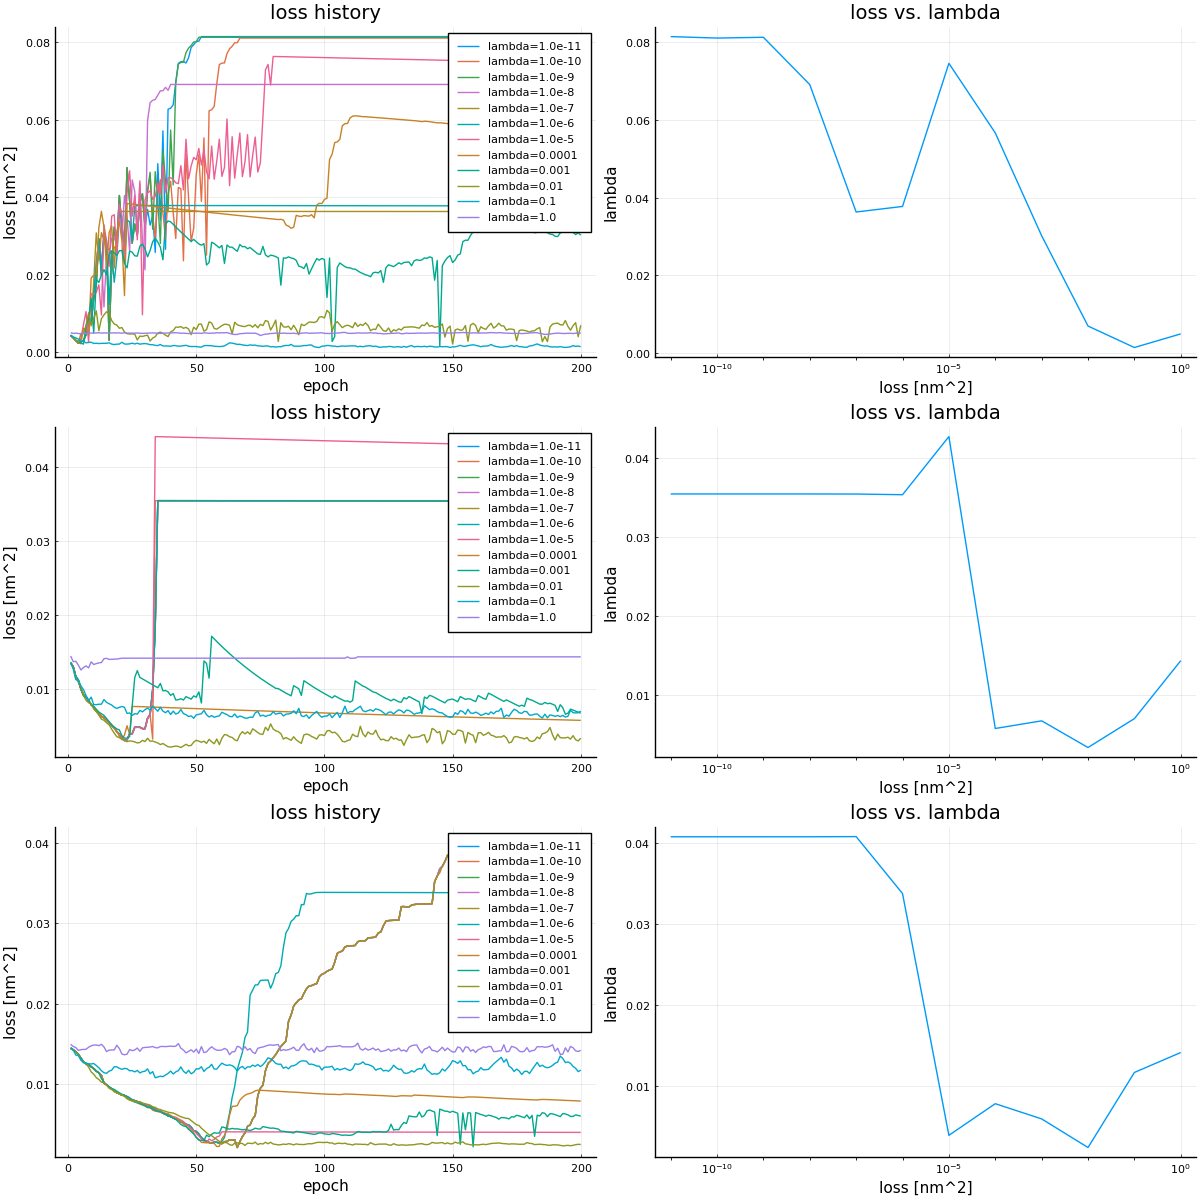

In [14]:
ps = Vector{Plots.Plot}(undef, 6)

for (i, results) in enumerate([normalResults, downScaledResults, largeGridResults])
    ps[2*i-1] = plot(xlabel="epoch", ylabel="loss [nm^2]", title="loss history")
    for it in eachindex(lambdas)
        plot!(ps[2*i-1], collect(1:max_epoch), results[it].loss_history, label="lambda=$(lambdas[it])")
    end

    ps[2*i] = plot(
        lambdas, [result.loss_history[end] for result in results],
        xaxis=:log, xlabel="loss [nm^2]", ylabel="lambda", title="loss vs. lambda", legend=nothing
    )
end

plot(ps..., layout=(3,2), size=(1200, 1200))

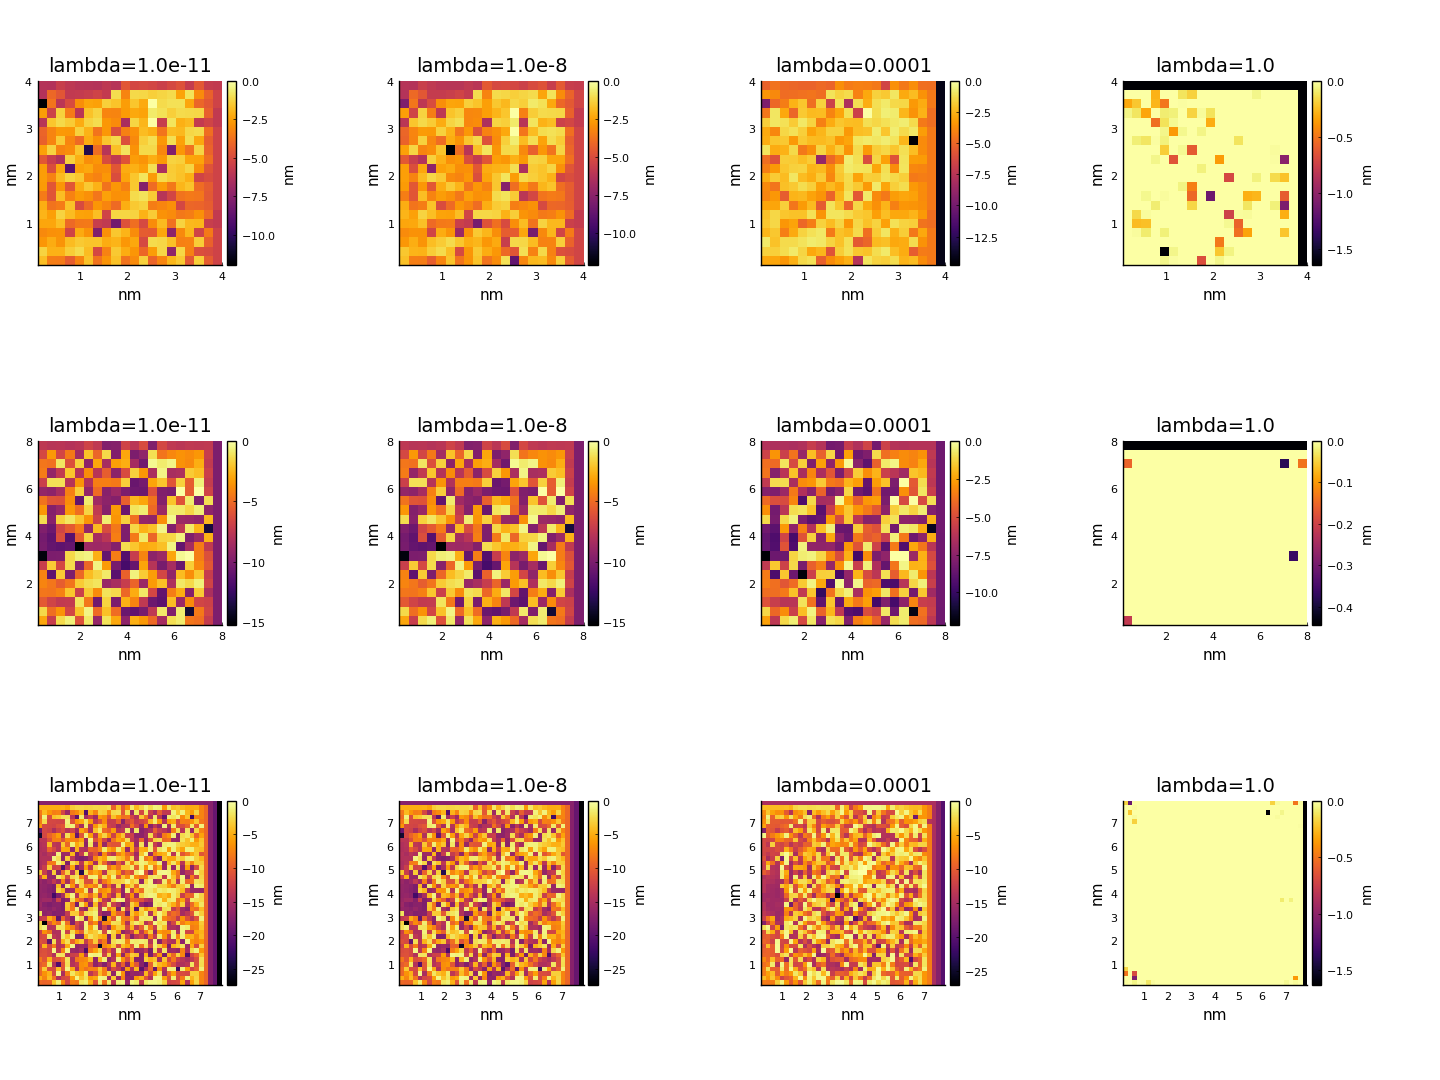

In [15]:
ps = Vector{Plots.Plot}(undef, 12)

titles = ["grid size:20, D.S. ratio:1", "grid size:20, D.S. ratio:2", "grid size:40, D.S. ratio:1"]
for (i, results) in enumerate([normalResults, downScaledResults, largeGridResults])
    row=(i-1)*4
    results_tmp = [results[1], results[4], results[8], results[12]]
    for (j, result) in enumerate(results_tmp)
        title = "$(titles[i]) (l=$(result.lambda))"
        ps[row+j] = SPM.Plots.heatmap(result.tip; title="lambda=$(result.lambda)")
    end
end
plot(ps..., layout=(3,4), size=(1440, 1080))